In [2]:
import cv2
import numpy as np
# import matplotlib.pyplot as plt

from cv02504.util_functions import *

In [3]:
# Q1: camera intrinsic matrix
K = camera_intrinsic(1200, (400,350), alpha=1, beta=0)
K

array([[1200,    0,  400],
       [   0, 1200,  350],
       [   0,    0,    1]])

In [4]:
# Q2: resizing image
Px = 0.4
print(Px*1000+400)
print(Px*500+200)

800.0
400.0


In [5]:
# Q3: projection
K = camera_intrinsic(1720, (680,610), 1, 0)
R = cv2.Rodrigues(np.array([-0.1, 0.1, -0.2]))[0]
t = np.array([[0.09], [0.05], [0.05]])
Q = np.array([[-0.03, 0.01, 0.59]]).T

print(Q.shape)

ans = project_points(K, R, t, Q)
ans

(3, 1)


array([[1023.50377104],
       [ 930.29756751]])

In [6]:
Rt = np.hstack((R, t))
ph = Pi(K @ Rt @ PiInv(Q))
ph

array([[1023.50377104],
       [ 930.29756751]])

In [9]:
# Q5: epipolar line
K = np.array([[900, 0, 1070], [0, 900, 610.0], [0, 0, 1]], float)
R1 = cv2.Rodrigues(np.array([-1.6, 0.3, -2.1]))[0]
t1 = np.array([[0.0], [1.0], [3.0]], float)
R2 = cv2.Rodrigues(np.array([-0.4, -1.3, -1.6]))[0]
t2 = np.array([[0.0], [1.0], [6.0]], float)
R3 = cv2.Rodrigues(np.array([2.5, 1.7, -0.4]))[0]
t3 = np.array([[2.0], [-7.0], [25.0]], float)

p1 = np.array([[1046.0], [453.0]])  # 2x1
p2 = np.array([[1126.0], [671.0]])
p3 = np.array([[1165.0], [453.0]])

F = fundamental_matrix(K, R1, t1, K, R2, t2)

epiline_c2 = F @ PiInv(p1)
dist = point_line_distance(epiline_c2, PiInv(p2))
dist

array([[13.27182907]])

In [ ]:
# Q6: triangulation without normalization
P1 = K @ np.hstack((R1, t1))
P2 = K @ np.hstack((R2, t2))
P3 = K @ np.hstack((R3, t3))

q1 = PiInv(p1)
q2 = PiInv(p2)
q3 = PiInv(p3)

Q = triangulate([q1, q2, q3], [P1, P2, P3])
Q

array([[3.10058867],
       [0.74321098],
       [0.46490561]])

In [ ]:
# Q11: distance from line
q = np.array([[2,4,3]]).T
l = np.array([[1,2,2]]).T
dist = point_line_distance(l, q)
dist

array([[2.38513918]])

dict_keys(['g*(I_x^2)', 'g*(I_y^2)', 'g*(I_x I_y)'])
r.shape: (5, 5)


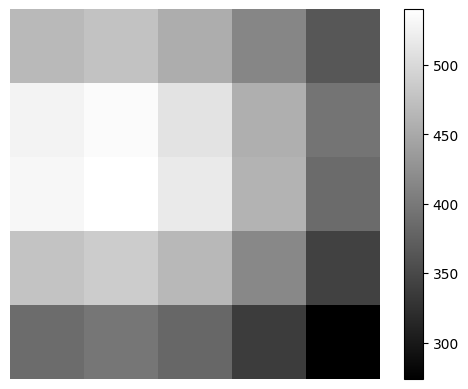

Corners found at [[2, 1]]


In [ ]:
# Q12: harris measure
data = np.load("media/harris.npy", allow_pickle=True).item()
print(data.keys())

gxx = data["g*(I_x^2)"]
gyy = data["g*(I_y^2)"]
gxy = data["g*(I_x I_y)"]

k = 0.06
tau = 516

# Structure tensor
C = np.array([[gxx, gxy], [gxy, gyy]])

# Harris measure
a = C[0, 0]
b = C[1, 1]
c = C[0, 1]
r = a * b - c**2 - k * (a + b) ** 2
print(f"r.shape: {r.shape}")

# Perform 4-neigbourhood non-max suppression
c = []
for i in range(1, gxx.shape[0] - 1):
    for j in range(1, gxx.shape[1] - 1):
        if (
            r[i, j] > r[i + 1, j]
            and r[i, j] >= r[i - 1, j]
            and r[i, j] > r[i, j + 1]
            and r[i, j] >= r[i, j - 1]
            and r[i, j] > tau
        ):  # Threshold
            c.append([i, j])

plt.imshow(r, cmap='gray')
plt.gca().invert_yaxis() # Origin at top-left corner
plt.axis('off')
plt.colorbar()
plt.show()
print(f"Corners found at {c}")

In [ ]:
# Q13: ransac 2D lines
data = np.load("media/ransac.npy", allow_pickle=True).item()
print(f"keys: {data.keys()}")

x1 = data["x1"] # (2,)
x2 = data["x2"]
points = data["points"]
tau = 0.2

# RANSAC
x1h = PiInv(x1.reshape(2,1))
x2h = PiInv(x2.reshape(2,1))
line = np.cross(x1h.squeeze(), x2h.squeeze())
line = line.reshape(3,1)

inliers = 0
for p in points.T:
    p = p.reshape(2,1)
    ph = PiInv(p)
    dist = point_line_distance(line, ph)
    if dist < tau:
        inliers += 1

print(f"No. of inliers: {inliers}")

keys: dict_keys(['points', 'x1', 'x2'])
No. of inliers: 34


In [ ]:
# Q14: ransac iterations
s = 103     # best number of inliers
m = 404     # total number of points
p = 0.95    # probability of only inliers
n = 4       # number of points to fit model

N = np.log(1-p) / np.log(1-(s/m)**n)
N

707.5554825030302

In [ ]:
# Q15: difference of gaussians, DoG
